In [1]:
# MobileNet - Integrisani gradijent (više slika)

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import torch.nn.functional as F
from torchvision.models import MobileNet_V3_Large_Weights

# Podešavanje uređaja
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Učitavanje MobileNetV3 modela
model = torchvision.models.mobilenet_v3_large(weights="DEFAULT")
model.eval().to(device)

# Definisanje transformacija
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Pomoćne funkcije
def denormalize_tensor_image(tensor_img, mean, std):
    img = tensor_img.squeeze().cpu().detach().numpy()
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    img = img * std + mean
    img = np.transpose(img, (1, 2, 0))
    return np.clip(img, 0, 1)


def attribute_image_features(algorithm, input, baselines=None, **kwargs):
    if baselines is None:
        baselines = input * 0
    return algorithm.attribute(input, baselines=baselines, **kwargs)


def run_pipeline(img_path, n_steps=200):
    # 1. Učitavanje slike
    original_img = Image.open(img_path).convert('RGB')
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    # 2. Predikcija
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    confidence = F.softmax(output, dim=1)[0, pred_class].item()
    class_names = MobileNet_V3_Large_Weights.DEFAULT.meta["categories"]
    pred_label = class_names[pred_class]

    # 3. Integrated Gradients
    ig = IntegratedGradients(model)
    attr_ig, delta = attribute_image_features(
        ig, input_tensor,
        target=pred_class,
        n_steps=n_steps,
        return_convergence_delta=True
    )
    attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

    # 4. Denormalizacija za vizualizaciju
    original_image = denormalize_tensor_image(
        input_tensor,
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )

    # 5. Prikaz
    plt.imshow(original_img)
    plt.title(f"Original Image\nPredicted: {pred_label}, Confidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()

    viz.visualize_image_attr(attr_ig, original_image,
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True,
                             title=f"Integrated Gradients\nClass: {pred_label} ({confidence:.2%})")

    print(f"Approximation delta: {abs(delta)}")

/Users/danilokacanski/Desktop/AUS Master/DL/DL/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


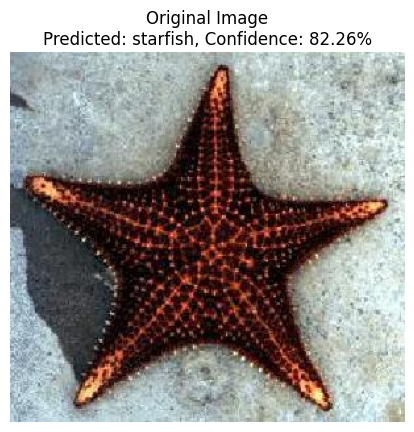

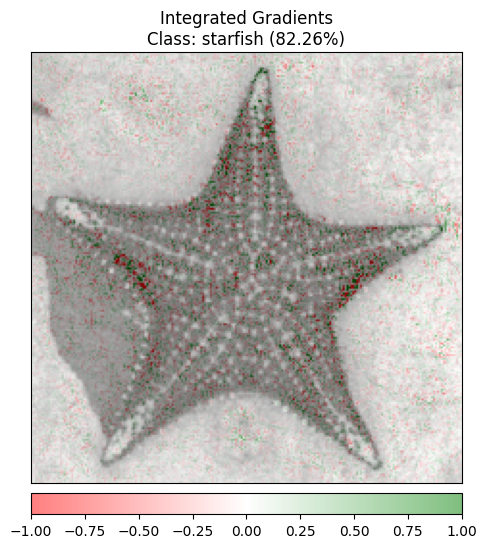

Approximation delta: tensor([0.1230], device='mps:0')


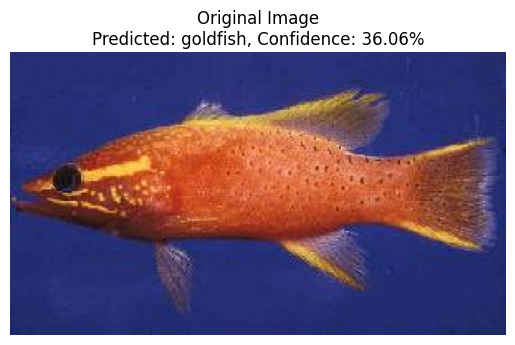

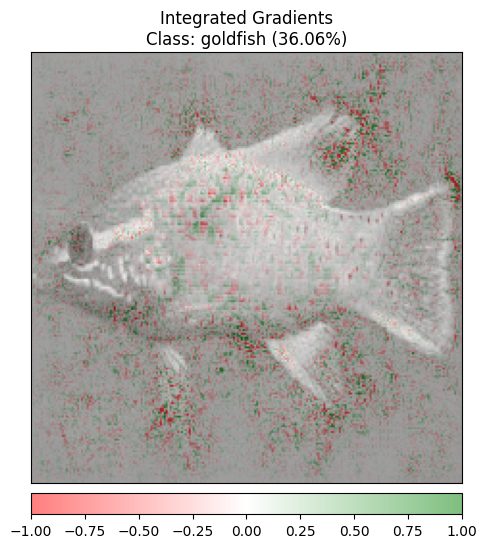

Approximation delta: tensor([0.0845], device='mps:0')


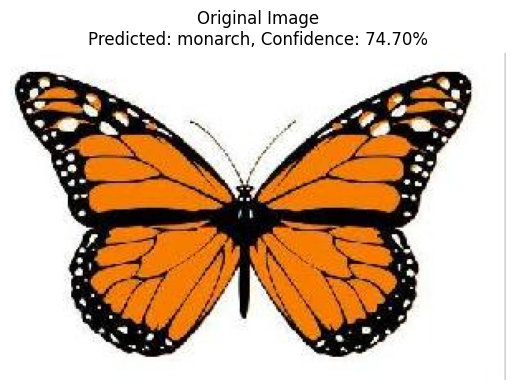

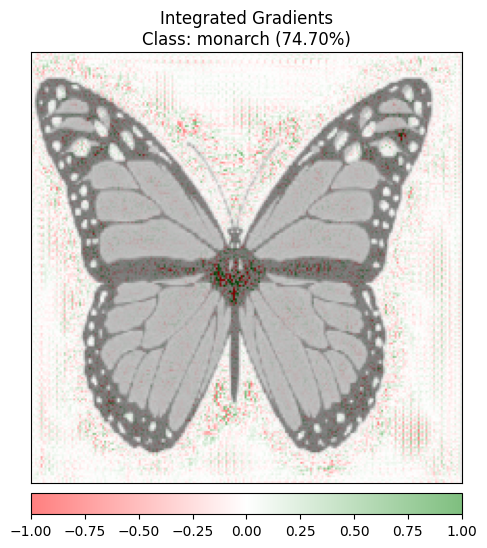

Approximation delta: tensor([0.5764], device='mps:0')


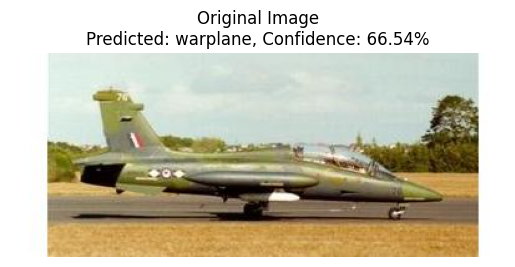

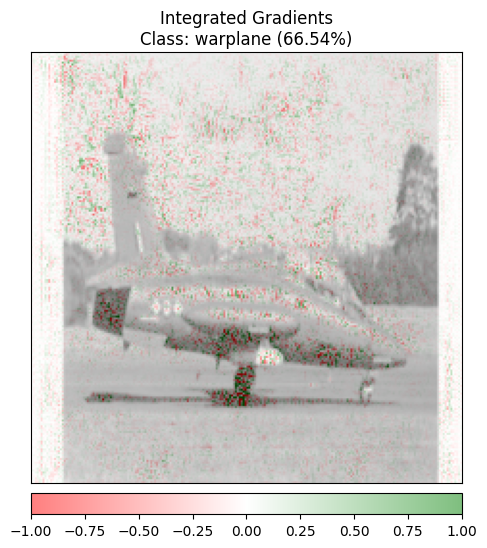

Approximation delta: tensor([0.0189], device='mps:0')


In [2]:
# Pokretanje na 4 slike
img_paths = [
    "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/starfish/image_0007.jpg",
    "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/bass/image_0001.jpg",
    "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/butterfly/image_0001.jpg",
    "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/airplanes/image_0001.jpg"
]
for path in img_paths:
    run_pipeline(path, n_steps=200)